In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def pupil_data_cleaning(pkl_file, csv_file, participant_num):
    
    ### Read pickle file ###
    f_1 = open(pkl_file, 'rb')
    
    gaze_data_container_1 = pickle.load(f_1)
    msg_container_1 = pickle.load(f_1)
    eye_openness_data_container_1 = pickle.load(f_1)
    external_signal_container_1 = pickle.load(f_1)
    sync_data_container_1 = pickle.load(f_1)
    stream_errors_container_1 = pickle.load(f_1)
    image_data_container_1 = pickle.load(f_1)
    calibration_history_1 = pickle.load(f_1)
    system_info_1 = pickle.load(f_1)
    
    f_1.close()
    
    gaze_data_container_df_1 = pd.DataFrame(gaze_data_container_1)
    gaze_data_container_df_1.columns = ['device_time_stamp',
    'system_time_stamp',
    'left_gaze_point_on_display_area_x',
    'left_gaze_point_on_display_area_y',
    'left_gaze_point_in_user_coordinate_system_x',
    'left_gaze_point_in_user_coordinate_system_y',
    'left_gaze_point_in_user_coordinate_system_z',
    'left_gaze_origin_in_trackbox_coordinate_system_x',
    'left_gaze_origin_in_trackbox_coordinate_system_y',
    'left_gaze_origin_in_trackbox_coordinate_system_z',
    'left_gaze_origin_in_user_coordinate_system_x',
    'left_gaze_origin_in_user_coordinate_system_y',
    'left_gaze_origin_in_user_coordinate_system_z',
    'left_pupil_diameter',
    'left_pupil_validity',
    'left_gaze_origin_validity',
    'left_gaze_point_validity',
    'right_gaze_point_on_display_area_x',
    'right_gaze_point_on_display_area_y',
    'right_gaze_point_in_user_coordinate_system_x',
    'right_gaze_point_in_user_coordinate_system_y',
    'right_gaze_point_in_user_coordinate_system_z',
    'right_gaze_origin_in_trackbox_coordinate_system_x',
    'right_gaze_origin_in_trackbox_coordinate_system_y',
    'right_gaze_origin_in_trackbox_coordinate_system_z',
    'right_gaze_origin_in_user_coordinate_system_x',
    'right_gaze_origin_in_user_coordinate_system_y',
    'right_gaze_origin_in_user_coordinate_system_z',
    'right_pupil_diameter',
    'right_pupil_validity',
    'right_gaze_origin_validity',
    'right_gaze_point_validity']
    
    ### Extract and add attributes ###
    pupil_diameter_1 = gaze_data_container_df_1[['system_time_stamp', 'left_pupil_diameter', 'left_pupil_validity', 'right_pupil_diameter', 
                                             'right_pupil_validity']]
    pupil_diameter_1.insert(pupil_diameter_1.shape[1], 'sound_num', 0)
    pupil_diameter_1.insert(pupil_diameter_1.shape[1], 'trial', 0)
    pupil_diameter_1.insert(pupil_diameter_1.shape[1], 'Liking', 0)
    pupil_diameter_1.insert(pupil_diameter_1.shape[1], 'Time since onset (s)', 0)
    pupil_diameter_1.insert(pupil_diameter_1.shape[1], 'partcipant', participant_num)
    
    ### Extract onset&offset time, add trial numbers ###
    msg_container_df_1 = pd.DataFrame(msg_container_1)
    onset_offset_1 = msg_container_df_1.tail(100)
    onset_offset_1.reset_index(drop = True, inplace = True)
    onset_offset_1.insert(onset_offset_1.shape[1], 'trial', 0)
    for row in range(0, 99, 2):
        onset_offset_1.loc[row, 'trial'] = row / 2 + 1    # Add trial numbers
        onset_offset_1.loc[row + 1, 'trial'] = row / 2 + 1
    
    ### Retrieve sounds with their time stamps ###
    for i in range(0, 99, 2):   # Retrieve time periods for sounds
        pupil_diameter_1.loc[(pupil_diameter_1['system_time_stamp']>=onset_offset_1.loc[i,0])&(pupil_diameter_1['system_time_stamp']<=onset_offset_1.loc[i+1,0]), 'sound_num']=onset_offset_1.loc[i,1]
        pupil_diameter_1.loc[(pupil_diameter_1['system_time_stamp']>=onset_offset_1.loc[i,0])&(pupil_diameter_1['system_time_stamp']<=onset_offset_1.loc[i+1,0]), 'trial']=onset_offset_1.loc[i,'trial']
    
    pupil_diameter_1 = pupil_diameter_1.drop(pupil_diameter_1[pupil_diameter_1['sound_num'] == 0].index)   # Drop data not for sounds
    for i in pupil_diameter_1.index:   # Adjust format of sound_num
        pupil_diameter_1.loc[i, 'sound_num'] = pupil_diameter_1.loc[i, 'sound_num'].split('_onset')[0]
        
    ### Append liking data ###
    p1_csv = pd.read_csv(csv_file)
    for i in p1_csv.index:
        pupil_diameter_1.loc[pupil_diameter_1['sound_num']==p1_csv.loc[i,'sounds'], 'Liking']=p1_csv.loc[i,'slider_rate.response']
        
    ### Reset index with sound_num ###
    pupil_diameter_1.set_index(['sound_num'], inplace=True)
    
    ### Calculate losses for left and right pupils data ###
    sound_list = []
    left_loss_list = []
    right_loss_list = []
    for i in range(1, 51):
        name = 'sounds/K%d.wav'%i
        sound_list.append(name)
        left_loss_list.append(1 - pupil_diameter_1.loc[name, :]['left_pupil_validity'].value_counts(1).loc[1])
        right_loss_list.append(1 - pupil_diameter_1.loc[name, :]['right_pupil_validity'].value_counts(1).loc[1])
    loss = {'P%d_sound_num'%participant_num: sound_list, 'P%d_left_pupil_loss'%participant_num: left_loss_list, 'P%d_right_pupil_loss'%participant_num: right_loss_list}
    loss_df = pd.DataFrame(loss)
    
    ### Linear interpolation ###
    pupil_diameter_1 = pupil_diameter_1.interpolate()
    
    ### Sort data from sound 1 to 50, append time in seconds ###
    final_pupil_diameter_1 = pupil_diameter_1.head(0)
    for sound in range(1, 51):
        trial = pupil_diameter_1.loc['sounds/K%d.wav'%sound, :].head(540)
        for i in range(0, 540):
            trial.iloc[i, 7] = i / 60 - 2
        final_pupil_diameter_1 = pd.concat([final_pupil_diameter_1, trial], axis=0)
        
    ### Rename final_pupil_diameter_1 ###
#     final_pupil_diameter_1.rename(columns = {"sound_num": "P%d_sound_num"%participant_num, 
#                                              "system_time_stamp":"P%d_system_time_stamp"%participant_num,
#                                              "left_pupil_diameter":"P%d_left_pupil_diameter"%participant_num,
#                                              "left_pupil_validity":"P%d_left_pupil_validity"%participant_num, 
#                                              "right_pupil_diameter":"P%d_right_pupil_diameter"%participant_num,
#                                              "right_pupil_validity":"P%d_right_pupil_validity"%participant_num,
#                                              "trial":"P%d_trial"%participant_num,
#                                              "liking":"P%d_liking"%participant_num,
#                                              "time":"P%d_time(s)"%participant_num},  inplace=True)

    
    return final_pupil_diameter_1, loss_df

In [3]:
P1_pupil_data, P1_loss = pupil_data_cleaning("p1.pkl", "p1_eyetracking_2022-10-06_10h57.47.442.csv", 1)
P2_pupil_data, P2_loss = pupil_data_cleaning("p2.pkl", "p2_eyetracking_2022-10-13_10h08.08.626.csv", 2)
P3_pupil_data, P3_loss = pupil_data_cleaning("p3.pkl", "p3_eyetracking_2022-10-13_10h27.09.184.csv", 3)
P4_pupil_data, P4_loss = pupil_data_cleaning("p4.pkl", "p4_eyetracking_2022-10-13_11h05.07.370.csv", 4)
P5_pupil_data, P5_loss = pupil_data_cleaning("p5.pkl", "p5_eyetracking_2022-10-13_11h28.05.898.csv", 5)
P6_pupil_data, P6_loss = pupil_data_cleaning("p6.pkl", "p6_eyetracking_2022-10-13_11h50.14.836.csv", 6)
P7_pupil_data, P7_loss = pupil_data_cleaning("p7.pkl", "p7_eyetracking_2022-10-14_13h11.25.856.csv", 7)
P8_pupil_data, P8_loss = pupil_data_cleaning("p8.pkl", "p8_eyetracking_2022-10-14_13h27.32.778.csv", 8)

C:\Users\Karl Zhang\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [67]:
P8_loss

,P8_sound_num,P8_left_pupil_loss,P8_right_pupil_loss
0,sounds/K1.wav,0.223333,0.238333
1,sounds/K2.wav,0.327787,0.364393
2,sounds/K3.wav,0.374376,0.394343
3,sounds/K4.wav,0.287854,0.304493
4,sounds/K5.wav,0.265546,0.272269
5,sounds/K6.wav,0.355000,0.390000
6,sounds/K7.wav,0.108153,0.119800
7,sounds/K8.wav,0.265000,0.276667
8,sounds/K9.wav,0.316140,0.356073
9,sounds/K10.wav,0.361065,0.399334


In [4]:
def level(df_pupil):
    df = df_pupil.copy()
    df.insert(df.shape[1], 'left_baseline', 0)
    df.insert(df.shape[1], 'right_baseline', 0)
    df.insert(df.shape[1], 'Left pupil dilation change (%)', 0)
    df.insert(df.shape[1], 'Right pupil dilation change (%)', 0)
    df.insert(df.shape[1], 'Complexity level', 'Low complexity')
    
    ### Calculate baseline and %change ###
    for i in range(0, 50):
        left_baseline = df.loc['sounds/K%d.wav'%(i+1), :].head(120)['left_pupil_diameter'].mean()
        right_baseline = df.loc['sounds/K%d.wav'%(i+1), :].head(120)['right_pupil_diameter'].mean()
        df.loc['sounds/K%d.wav'%(i+1), 'left_baseline'] = left_baseline
        df.loc['sounds/K%d.wav'%(i+1), 'right_baseline'] = right_baseline
        for j in range(0, 540):
            df.iloc[i*540+j, 11] = ((df.iloc[i*540+j, 1] - left_baseline) / left_baseline) * 100
            df.iloc[i*540+j, 12] = ((df.iloc[i*540+j, 3] - right_baseline) / right_baseline) * 100
            
    ### Divide levels ###
    for i in range(17, 35):
        df.loc['sounds/K%d.wav'%i, 'Complexity level']='Medium complexity'
    for i in range(35, 51):
        df.loc['sounds/K%d.wav'%i, 'Complexity level']='High complexity'
        
    ### Keep data only when sound played ###
    final_df = df.head(0)
    for i in range(1, 51):
        trial = df.loc['sounds/K%d.wav'%i, :].iloc[120:480, :]
        final_df = pd.concat([final_df, trial], axis=0)
    
    return final_df

In [5]:
P1 = level(P1_pupil_data)
P2 = level(P2_pupil_data)
P3 = level(P3_pupil_data)
P4 = level(P4_pupil_data)
P5 = level(P5_pupil_data)
P6 = level(P6_pupil_data)
P7 = level(P7_pupil_data)
P8 = level(P8_pupil_data)

In [6]:
combine = pd.concat([P1, P2], axis=0)
combine = pd.concat([combine, P3], axis=0)
combine = pd.concat([combine, P4], axis=0)
combine = pd.concat([combine, P5], axis=0)
combine = pd.concat([combine, P6], axis=0)
combine = pd.concat([combine, P7], axis=0)
combine = pd.concat([combine, P8], axis=0)

In [7]:
combine

,system_time_stamp,left_pupil_diameter,left_pupil_validity,right_pupil_diameter,right_pupil_validity,trial,Liking,Time since onset (s),partcipant,left_baseline,right_baseline,Left pupil dilation change (%),Right pupil dilation change (%),Complexity level
sound_num,,,,,,,,,,,,,,
sounds/K1.wav,313828973690,5.396667,1,4.586014,1,44,3.0,0.000000,1,5.080847,4.334596,6.215897,5.800268,Low complexity
sounds/K1.wav,313828990344,5.402542,1,4.587708,1,44,3.0,0.016667,1,5.080847,4.334596,6.331520,5.839343,Low complexity
sounds/K1.wav,313829006999,5.402542,1,4.584106,1,44,3.0,0.033333,1,5.080847,4.334596,6.331520,5.756265,Low complexity
sounds/K1.wav,313829023654,5.404602,1,4.583557,1,44,3.0,0.050000,1,5.080847,4.334596,6.372064,5.743593,Low complexity
sounds/K1.wav,313829040310,5.404602,1,4.583817,1,44,3.0,0.066667,1,5.080847,4.334596,6.372064,5.749577,Low complexity
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sounds/K50.wav,164285952490,3.861148,0,3.877188,0,37,7.0,5.916667,8,4.025676,4.169412,-4.086972,-7.008777,High complexity
sounds/K50.wav,164285969145,3.859516,0,3.879257,0,37,7.0,5.933333,8,4.025676,4.169412,-4.127494,-6.959154,High complexity
sounds/K50.wav,164285985800,3.857885,0,3.881326,0,37,7.0,5.950000,8,4.025676,4.169412,-4.168016,-6.909531,High complexity


<Figure size 48000x32000 with 0 Axes>

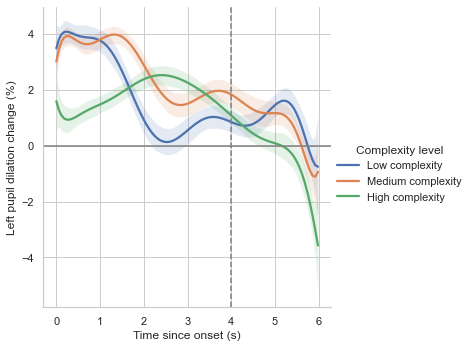

In [57]:
plt.figure(dpi=8000)
sns.set_theme(style="whitegrid")
sns.lmplot(x='Time since onset (s)', y='Left pupil dilation change (%)', data=combine[combine['partcipant']==1], hue='Complexity level', ci=95, order=10, scatter=False)
plt.axhline(y=0.0, c="grey")
plt.axvline(x=4.0, c="grey", ls="--")

<Figure size 48000x32000 with 0 Axes>

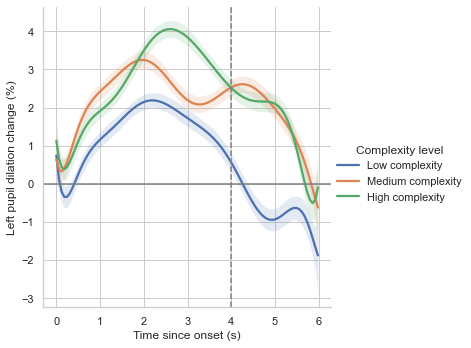

In [8]:
plt.figure(dpi=8000)
sns.set_theme(style="whitegrid")
sns.lmplot(x='Time since onset (s)', y='Left pupil dilation change (%)', data=combine, hue='Complexity level', ci=95, order=10, scatter=False)
plt.axhline(y=0.0, c="grey")
plt.axvline(x=4.0, c="grey", ls="--")
plt.savefig('left pupil complexity.png')

<Figure size 48000x32000 with 0 Axes>

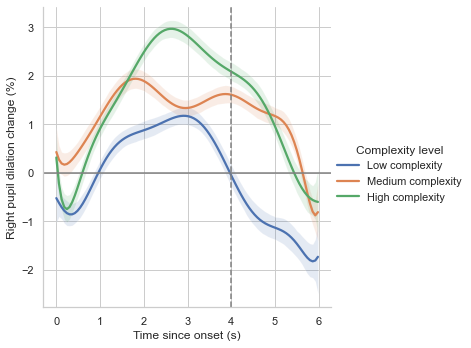

In [9]:
plt.figure(dpi=8000)
sns.set_theme(style="whitegrid")
sns.lmplot(x='Time since onset (s)', y='Right pupil dilation change (%)', data=combine, hue='Complexity level', ci=95, order=10, scatter=False)
plt.axhline(y=0.0, c="grey")
plt.axvline(x=4.0, c="grey", ls="--")
plt.savefig('right pupil complexity.png')

<Figure size 48000x32000 with 0 Axes>

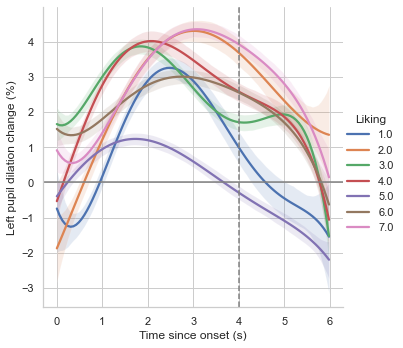

In [10]:
plt.figure(dpi=8000)
sns.set_theme(style="whitegrid")
sns.lmplot(x='Time since onset (s)', y='Left pupil dilation change (%)', data=combine, hue='Liking', order=5, scatter=False)
plt.axhline(y=0.0, c="grey")
plt.axvline(x=4.0, c="grey", ls="--")
# plt.savefig('right pupil.png')

<Figure size 48000x32000 with 0 Axes>

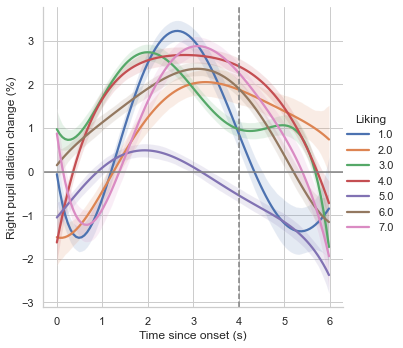

In [11]:
plt.figure(dpi=8000)
sns.set_theme(style="whitegrid")
sns.lmplot(x='Time since onset (s)', y='Right pupil dilation change (%)', data=combine, hue='Liking', order=5, scatter=False)
plt.axhline(y=0.0, c="grey")
plt.axvline(x=4.0, c="grey", ls="--")
# plt.savefig('right pupil.png')

In [12]:
def like(df_pupil):
    df = df_pupil.copy()
    df.insert(df.shape[1], 'Liking level', 'In between')
    for i in range(0, 144000):
        if df.iloc[i, 6] < 3:
            df.iloc[i, 14] = 'Dislike'
        if df.iloc[i, 6] > 5:
            df.iloc[i, 14] = 'Like'
    return df

In [13]:
temp = like(combine)

In [14]:
temp.to_csv('cleaned_data.csv')

In [42]:
temp[temp['partcipant']==6]

,system_time_stamp,left_pupil_diameter,left_pupil_validity,right_pupil_diameter,right_pupil_validity,trial,Liking,Time since onset (s),partcipant,left_baseline,right_baseline,Left pupil dilation change (%),Right pupil dilation change (%),Complexity level,Liking level
sound_num,,,,,,,,,,,,,,,
sounds/K1.wav,71918856198,3.620514,1,2.922386,0,35,3.0,0.000000,6,3.630090,3.205063,-0.263787,-8.819687,Low complexity,In between
sounds/K1.wav,71918872853,3.613419,1,3.165604,1,35,3.0,0.016667,6,3.630090,3.205063,-0.459246,-1.231147,Low complexity,In between
sounds/K1.wav,71918889507,3.608627,1,3.140732,1,35,3.0,0.033333,6,3.630090,3.205063,-0.591234,-2.007164,Low complexity,In between
sounds/K1.wav,71918906163,3.615540,1,2.826080,1,35,3.0,0.050000,6,3.630090,3.205063,-0.400819,-11.824491,Low complexity,In between
sounds/K1.wav,71918922818,3.605392,1,3.257309,1,35,3.0,0.066667,6,3.630090,3.205063,-0.680346,1.630117,Low complexity,In between
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sounds/K50.wav,71813633725,3.871216,1,3.452225,1,27,4.0,5.916667,6,3.824517,3.453467,1.221032,-0.035973,High complexity,In between
sounds/K50.wav,71813650380,3.809448,1,3.406479,1,27,4.0,5.933333,6,3.824517,3.453467,-0.394011,-1.360609,High complexity,In between
sounds/K50.wav,71813667035,3.819519,1,3.369751,1,27,4.0,5.950000,6,3.824517,3.453467,-0.130689,-2.424117,High complexity,In between


<Figure size 48000x32000 with 0 Axes>

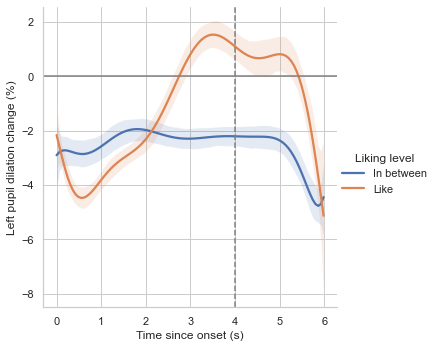

In [46]:
plt.figure(dpi=8000)
sns.set_theme(style="whitegrid")
sns.lmplot(x='Time since onset (s)', y='Left pupil dilation change (%)', data=temp[temp['partcipant']==4], hue='Liking level', ci=95, order=10, scatter=False)
plt.axhline(y=0.0, c="grey")
plt.axvline(x=4.0, c="grey", ls="--")

<Figure size 48000x32000 with 0 Axes>

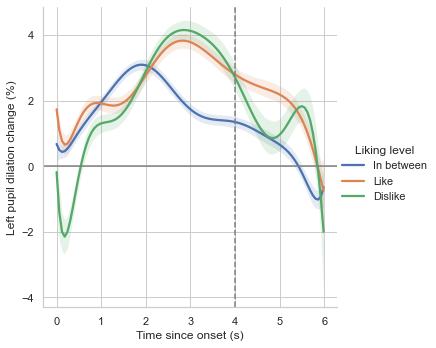

In [15]:
plt.figure(dpi=8000)
sns.set_theme(style="whitegrid")
sns.lmplot(x='Time since onset (s)', y='Left pupil dilation change (%)', data=temp, hue='Liking level', ci=95, order=10, scatter=False)
plt.axhline(y=0.0, c="grey")
plt.axvline(x=4.0, c="grey", ls="--")
plt.savefig('left pupil liking.png')

<Figure size 48000x32000 with 0 Axes>

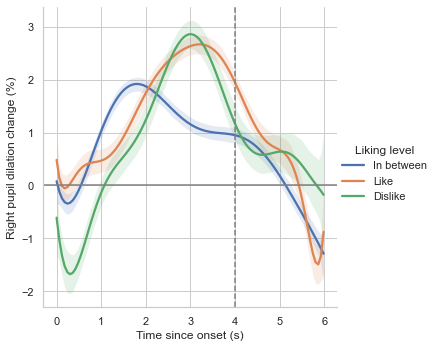

In [16]:
plt.figure(dpi=8000)
sns.set_theme(style="whitegrid")
sns.lmplot(x='Time since onset (s)', y='Right pupil dilation change (%)', data=temp, hue='Liking level', ci=95, order=10, scatter=False)
plt.axhline(y=0.0, c="grey")
plt.axvline(x=4.0, c="grey", ls="--")
plt.savefig('right pupil liking.png')

In [17]:
csv1 = pd.read_csv('p1_eyetracking_2022-10-06_10h57.47.442.csv')
csv2 = pd.read_csv('p2_eyetracking_2022-10-13_10h08.08.626.csv')
csv3 = pd.read_csv('p3_eyetracking_2022-10-13_10h27.09.184.csv')
csv4 = pd.read_csv('p4_eyetracking_2022-10-13_11h05.07.370.csv')
csv5 = pd.read_csv('p5_eyetracking_2022-10-13_11h28.05.898.csv')
csv6 = pd.read_csv('p6_eyetracking_2022-10-13_11h50.14.836.csv')
csv7 = pd.read_csv('p7_eyetracking_2022-10-14_13h11.25.856.csv')
csv8 = pd.read_csv('p8_eyetracking_2022-10-14_13h27.32.778.csv')

In [18]:
sound_list = []
sound_num = []
for i in range(1, 51):
    sound_list.append('sounds/K%d.wav'%i)
    sound_num.append(i)

In [19]:
liking_df = pd.DataFrame(columns=['sound','Number of the music excerpts','p1','p2','p3','p4','p5','p6','p7','p8','Average liking rate'], index=sound_num)

In [20]:
liking_df.loc[:,'sound'] = sound_list
liking_df.loc[:,'Number of the music excerpts'] = sound_num

In [21]:
liking_df

,sound,Number of the music excerpts,p1,p2,p3,p4,p5,p6,p7,p8,Average liking rate
1,sounds/K1.wav,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sounds/K2.wav,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sounds/K3.wav,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sounds/K4.wav,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,sounds/K5.wav,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,sounds/K6.wav,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,sounds/K7.wav,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,sounds/K8.wav,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,sounds/K9.wav,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,sounds/K10.wav,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
for i in csv1.index:
    liking_df.loc[liking_df['sound']==csv1.loc[i,'sounds'],'p1']=csv1.loc[i,'slider_rate.response']
for i in csv2.index:
    liking_df.loc[liking_df['sound']==csv2.loc[i,'sounds'],'p2']=csv2.loc[i,'slider_rate.response']
for i in csv3.index:
    liking_df.loc[liking_df['sound']==csv3.loc[i,'sounds'],'p3']=csv3.loc[i,'slider_rate.response']
for i in csv4.index:
    liking_df.loc[liking_df['sound']==csv4.loc[i,'sounds'],'p4']=csv4.loc[i,'slider_rate.response']
for i in csv5.index:
    liking_df.loc[liking_df['sound']==csv5.loc[i,'sounds'],'p5']=csv5.loc[i,'slider_rate.response']
for i in csv6.index:
    liking_df.loc[liking_df['sound']==csv6.loc[i,'sounds'],'p6']=csv6.loc[i,'slider_rate.response']
for i in csv7.index:
    liking_df.loc[liking_df['sound']==csv7.loc[i,'sounds'],'p7']=csv7.loc[i,'slider_rate.response']
for i in csv8.index:
    liking_df.loc[liking_df['sound']==csv8.loc[i,'sounds'],'p8']=csv8.loc[i,'slider_rate.response']

In [23]:
liking_df['Average liking rate']=liking_df[['p1','p2','p3','p4','p5','p6','p7','p8']].mean(axis=1)

In [24]:
liking_df

,sound,Number of the music excerpts,p1,p2,p3,p4,p5,p6,p7,p8,Average liking rate
1,sounds/K1.wav,1,3.0,6.0,3.0,1.0,2.0,3.0,1.0,1.0,2.500
2,sounds/K2.wav,2,3.0,6.0,3.0,4.0,2.0,5.0,1.0,1.0,3.125
3,sounds/K3.wav,3,3.0,1.0,3.0,2.0,2.0,2.0,3.0,5.0,2.625
4,sounds/K4.wav,4,3.0,4.0,4.0,2.0,3.0,3.0,1.0,4.0,3.000
5,sounds/K5.wav,5,3.0,3.0,4.0,5.0,4.0,2.0,2.0,5.0,3.500
6,sounds/K6.wav,6,5.0,2.0,4.0,3.0,2.0,3.0,1.0,5.0,3.125
7,sounds/K7.wav,7,3.0,4.0,4.0,1.0,3.0,5.0,3.0,4.0,3.375
8,sounds/K8.wav,8,4.0,5.0,4.0,5.0,4.0,4.0,1.0,3.0,3.750
9,sounds/K9.wav,9,3.0,4.0,3.0,1.0,2.0,4.0,1.0,2.0,2.500
10,sounds/K10.wav,10,5.0,5.0,4.0,3.0,5.0,3.0,1.0,1.0,3.375


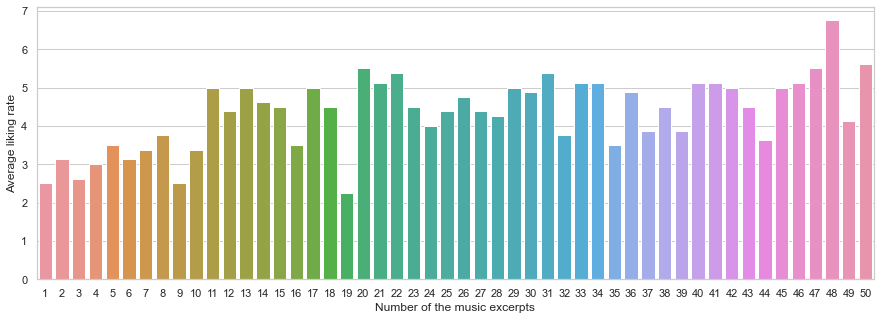

In [25]:
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='Number of the music excerpts', y='Average liking rate', data=liking_df)
plt.savefig('liking rate.png')

In [26]:
liking1 = liking_df[['Number of the music excerpts', 'p1']]
liking2 = liking_df[['Number of the music excerpts', 'p2']]
liking3 = liking_df[['Number of the music excerpts', 'p3']]
liking4 = liking_df[['Number of the music excerpts', 'p4']]
liking5 = liking_df[['Number of the music excerpts', 'p5']]
liking6 = liking_df[['Number of the music excerpts', 'p6']]
liking7 = liking_df[['Number of the music excerpts', 'p7']]
liking8 = liking_df[['Number of the music excerpts', 'p8']]

In [27]:
liking1.rename(columns = {"p1": "Liking rate"},  inplace=True)
liking2.rename(columns = {"p2": "Liking rate"},  inplace=True)
liking3.rename(columns = {"p3": "Liking rate"},  inplace=True)
liking4.rename(columns = {"p4": "Liking rate"},  inplace=True)
liking5.rename(columns = {"p5": "Liking rate"},  inplace=True)
liking6.rename(columns = {"p6": "Liking rate"},  inplace=True)
liking7.rename(columns = {"p7": "Liking rate"},  inplace=True)
liking8.rename(columns = {"p8": "Liking rate"},  inplace=True)

C:\Users\Karl Zhang\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [28]:
tp = pd.concat([liking1, liking2], axis=0)
tp = pd.concat([tp, liking3], axis=0)
tp = pd.concat([tp, liking4], axis=0)
tp = pd.concat([tp, liking5], axis=0)
tp = pd.concat([tp, liking6], axis=0)
tp = pd.concat([tp, liking7], axis=0)
tp = pd.concat([tp, liking8], axis=0)

<Figure size 1080x360 with 0 Axes>

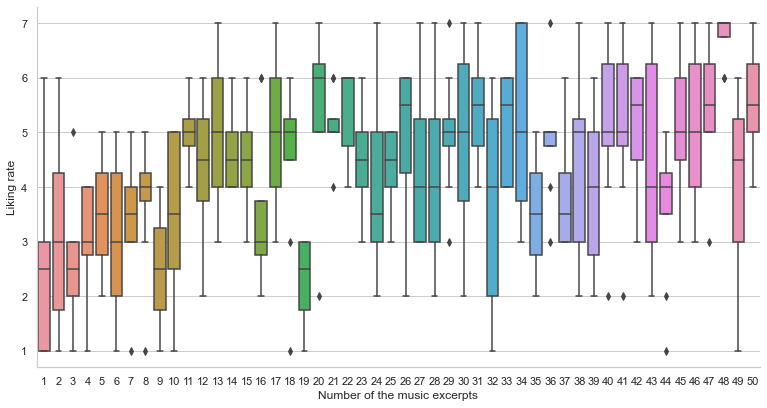

In [29]:
# sns.set_context({'figure.figsize':[20, 5]})
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
ax = sns.catplot(data=tp, x='Number of the music excerpts', y='Liking rate', kind='box')
ax.figure.set_size_inches(12,6)
plt.savefig('like_try.png')

<AxesSubplot:xlabel='Number of the music excerpts', ylabel='Liking rate'>

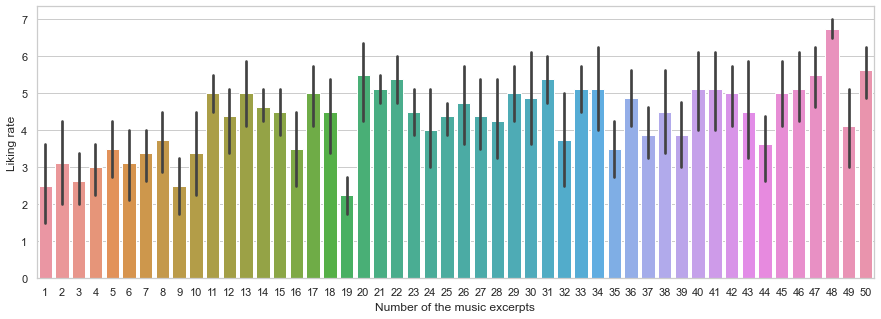

In [30]:
plt.figure(figsize=(15,5))
sns.set_theme(style="whitegrid")
sns.barplot(x='Number of the music excerpts', y='Liking rate', data=tp)

In [31]:
tp.insert(tp.shape[1], 'Complexity level of the music', 'low complexity')

In [32]:
for i in range(17, 35):
    tp.loc[i, 'Complexity level of the music']='medium complexity'
for i in range(35, 51):
    tp.loc[i, 'Complexity level of the music']='high complexity'

In [33]:
tp

,Number of the music excerpts,Liking rate,Complexity level of the music
1,1,3.0,low complexity
2,2,3.0,low complexity
3,3,3.0,low complexity
4,4,3.0,low complexity
5,5,3.0,low complexity
...,...,...,...
46,46,3.0,high complexity
47,47,6.0,high complexity
48,48,7.0,high complexity
49,49,6.0,high complexity


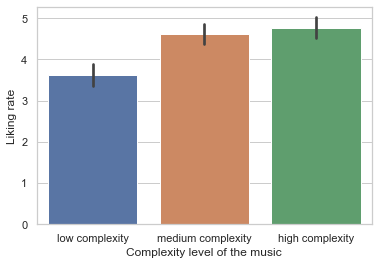

In [34]:
#plt.figure(figsize=())
sns.set_theme(style="whitegrid")
sns.barplot(x='Complexity level of the music', y='Liking rate', data=tp)
plt.savefig('average liking.png')

In [35]:
mean_tp = np.mean(tp.loc[tp['Complexity level of the music']=='high complexity']['Liking rate'])
std_tp = np.std(tp.loc[tp['Complexity level of the music']=='high complexity']['Liking rate'])

In [36]:
print(mean_tp, std_tp)

4.7578125 1.559978434095725
